In [1]:
import cosima_cookbook as cc
import cmocean as cm
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numpy import unravel_index
import matplotlib.colors as colors
%matplotlib inline

In [2]:
from dask.distributed import Client
client = Client()
client.amm.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44735,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:38543,Total threads: 1
Dashboard: /proxy/37523/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38585,


In [3]:
## Since we use conservative temperature, we take reference values for density and specific heat capacity for ACCESS-OM2 to make figures 1 and 2.

ρ0 = 1035 # kg / m3
Cp = 3992.10322329649  # J / (kg C)

## Figure 1: Streamfunction and heatfunction plots for wind stress perturbation experiments for the first 10 and last 50 years of the simulation

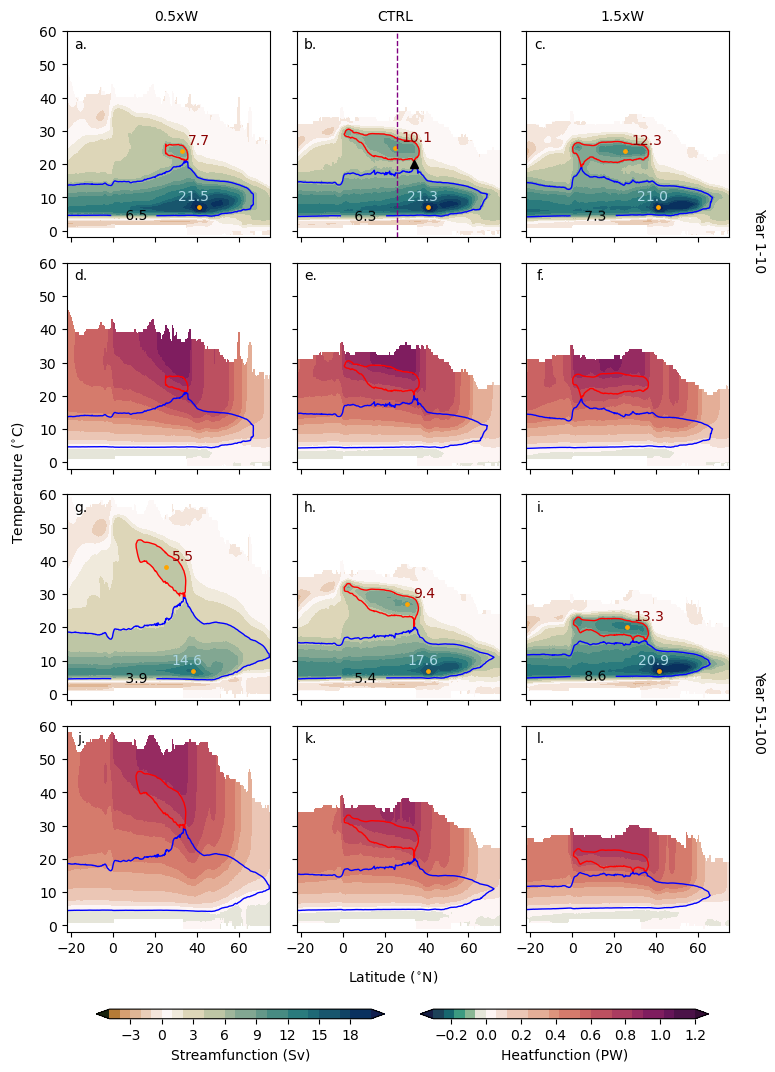

In [4]:
ϵ = 1e-3
expt = ['050xS', 'CTRL', '150xS']
label_series = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.', 'h.', 'i.', 'j.', 'k.', 'l.']

# Streamfunction plots (First 10 years (a-c) and last 50 years (g-i))
# Heatfunction plots(First 10 years (d-f) and last 50 years (h-l))

# Step 1: Non-uniform colorbar preparation for streamfunction (Ψ) and heatfunction (α)
vminΨ, vmaxΨ = -5, 20
clevΨ  = np.linspace(vminΨ, vmaxΨ, (vmaxΨ - vminΨ) + 1)
divnΨ  = colors.TwoSlopeNorm(vmin = vminΨ * 2, vcenter = 0., vmax = vmaxΨ)
vminα, vmaxα = -0.3, 1.2
clevα = np.linspace(vminα, vmaxα, 26)
divnα  = colors.TwoSlopeNorm(vmin = vminα, vcenter = 0., vmax = vmaxα)

# Step 2: Declare variables for maximum value of the streamfunction at warm and cold temperatures (resembling the subtropical gyre 
# and the dense overturning circulation respectively)
Ψmax_gyre = np.zeros((3, 2))
Ψmax_AMOC = np.zeros((3, 2))

# Step 3: Pick start (st) and end (et) dates of interest (here chosen to be first 10 and last 50 years)
st = ['2202-01-01', '2252-01-01']
et = ['2211-12-31', '2301-12-31']

# Step 4: Location of data (will be available at a Zenodo repository upon acceptance of manuscript)
dirc1 = '/g/data/x77/db6174/MHT_calculations/NETCDF/Heatfunction_split/Psi_components/'
dirc2 = '/scratch/x77/db6174/MHT_FF11/Psi_Atlantic_temperature_space/'

# Step 5: Creating figures with required panels
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (6 * 1.2, 8 * 1.2))

# The variable i and j are used to reference to experiments and time periods of interest respectively
for i in range(3):
    for j in range(2):
        
        if(j == 0):         # First 10 years
            Ψs = xr.load_dataset(dirc1 + expt[i] + '_10yr_avg.nc').Mixed.sel(time = slice(st[j], et[j]))
            θs = xr.load_dataset(dirc1 + expt[i] + '_10yr_avg.nc').Saddle_temp.sel(time = slice(st[j], et[j]))
        elif(j == 1):       # Last 10 years
            Ψs = xr.load_dataset(dirc1 + expt[i] + '_50yr_avg.nc').Mixed.sel(time = slice(st[j], et[j]))
            θs = xr.load_dataset(dirc1 + expt[i] + '_50yr_avg.nc').Saddle_temp.sel(time = slice(st[j], et[j]))

        # Referring to the first 10 years of the control simulaton
        if(i == 1 and j == 0):
            θs_CTRL = θs.item()
            ys_CTRL = θs.yu_ocean.item()
        Ψ =  xr.load_dataset(dirc2 + expt[i] + '.nc').AMOC.sel(time = slice(st[j], et[j])).mean('time').rolling(temp = 2, min_periods = 1).mean()

        ## Creating streamfunction plots
        Ψ_cor = xr.where(Ψ == Ψ.isel(temp = -1), np.nan, xr.where(Ψ == 0, np.nan, Ψ)).sel(yu_ocean = slice(-22, None))
        p1 = Ψ_cor.plot.contourf(y = 'temp', levels = clevΨ, cmap = cm.cm.tarn,   ax = axes[j*2][i], add_colorbar = False, norm = divnΨ, extend = 'both')
        p4 = Ψ_cor.where(Ψ_cor.temp >= θs[0].values).plot.contour(y = 'temp', ax = axes[j*2][i], levels = np.linspace(Ψs[0].values, Ψs[0].values + ϵ, 1), cmap = 'red', linewidths = 1)
        p3 = Ψ_cor.where(Ψ_cor.temp <= θs[0].values).plot.contour(y = 'temp', ax = axes[j*2][i], levels = np.linspace(Ψs[0].values, Ψs[0].values + ϵ, 1), cmap = 'blue', linewidths = 1)
        axes[j*2][i].clabel(p3, p3.levels, inline = True, fmt ='% 1.1f', fontsize = 10, colors = 'black', manual = [(10, 5)])
        
        ## Finding maximum warm cell streamfunction value and plotting it as text
        temp_array = Ψ_cor.where(Ψ_cor.temp >= θs[0].values)
        Ψmax_gyre[i][j] = temp_array.max().values
        index = unravel_index(temp_array.argmax(), temp_array.shape)
        x, y = temp_array[index].temp.values.item(), temp_array[index].yu_ocean.values.item()
        axes[j*2][i].scatter(y, x, marker = 'o', color = 'orange', s = 6)
        axes[j*2][i].text(y + 3, x + 2, np.round(Ψmax_gyre[i][j], 1), color = 'darkred')

        ## Finding maximum cold cell streamfunction value and plotting it as text
        temp_array = Ψ_cor.where(Ψ_cor.temp <= θs[0].values)
        Ψmax_AMOC[i][j] = temp_array.max().values
        index = unravel_index(temp_array.argmax(), temp_array.shape)
        x, y = temp_array[index].temp.values.item(), temp_array[index].yu_ocean.values.item()
        axes[j*2][i].scatter(y, x, marker = 'o', color = 'orange', s = 6)
        axes[j*2][i].text(y - 10, x + 2, np.round(Ψmax_AMOC[i][j], 1), color = 'lightblue')

        ## Creating heatfunction plots
        α = Ψ_cor.cumsum('temp') * ((ρ0 * Cp * 1e6)/(1e15))
        α_cor = xr.where(α == α.isel(temp = -1), np.nan, xr.where(α == 0, np.nan, α)).sel(yu_ocean = slice(-22, None))
        p2 = α_cor.plot.contourf(y = 'temp', levels = clevα, cmap = cm.cm.curl, ax = axes[j*2+1][i], add_colorbar = False, norm = divnα, extend = 'both')
        p4 = Ψ_cor.where(Ψ_cor.temp >= θs[0].values).plot.contour(y = 'temp', ax = axes[j*2+1][i], levels = np.linspace(Ψs[0].values, Ψs[0].values + ϵ, 1), cmap = 'red', linewidths = 1)
        p3 = Ψ_cor.where(Ψ_cor.temp <= θs[0].values).plot.contour(y = 'temp', ax = axes[j*2+1][i], levels = np.linspace(Ψs[0].values, Ψs[0].values + ϵ, 1), cmap = 'blue', linewidths = 1)

## x and y ticks
for i in range(4):
    for j in range(3):
        axes[i][j].set_ylabel('')
        axes[i][j].set_xlabel('')
        axes[i][j].set_xticks([-20, 0, 20, 40, 60])
        axes[i][j].set_yticks([0, 10, 20, 30, 40, 50, 60])
        axes[i][j].set_title(label_series[i*3 + j], fontsize = 10, x = 0.07, y = 1, pad = -12)

# Ensuring that only the last row has xticks printed, others are left blank
for i in range(3):
    for j in range(3):
        axes[i][j].set_xticklabels([])

# Ensuring that only the first column has yticks printed, others are left blank
for i in range(2):
    for j in range(4):
        axes[j][i+1].set_yticklabels([])

# Plotting 26N in the first 10 years of the control simulation to highlight which latitude we pick to summarize our results
axes[0][1].axvline(26, ls = '--', color = 'purple', lw = 1)
axes[0][1].plot(ys_CTRL, θs_CTRL, marker = '^', color = 'black', markersize = 6)

## Colorbars
# Colorbar 1: Overturning circulation
ax_cb = plt.axes([0.1, -0.05, 0.4, 0.01])
cb = plt.colorbar(p1, cax = ax_cb, orientation = 'horizontal')
cb.ax.set_xlabel('Streamfunction (Sv)', fontsize = 10)

# Colorbar 2: Heatfunction value
ax_cb = plt.axes([0.55, -0.05, 0.4, 0.01])
cb = plt.colorbar(p2, cax = ax_cb, orientation = 'horizontal')
cb.ax.set_xlabel('Heatfunction (PW)', fontsize = 10)
cb.ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])

# Labelling perturbation experiments
fig.text(0.18, 0.99, '0.5xW')
fig.text(0.49, 0.99, 'CTRL')
fig.text(0.8, 0.99, '1.5xW')

## First 10 vs last 50 years labeling
fig.text(1.01, 0.73, 'Year 1-10', rotation = -90)
fig.text(1.01, 0.23, 'Year 51-100', rotation = -90)

## x and y labels
fig.text(-0.02, 0.45, 'Temperature ($^{\circ}$C)', rotation = 90)
fig.text(0.45, -0.01, 'Latitude ($^{\circ}$N)')


fig.tight_layout()

#plt.savefig('/g/data/x77/db6174/MHT_calculations/2024_paper_figures/Figures/Wind_streamfunction_heatfunction.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## Figure 2: Streamfunction and heatfunction plots for the surface heat flux perturbation experiments for the first 10 and last 50 years

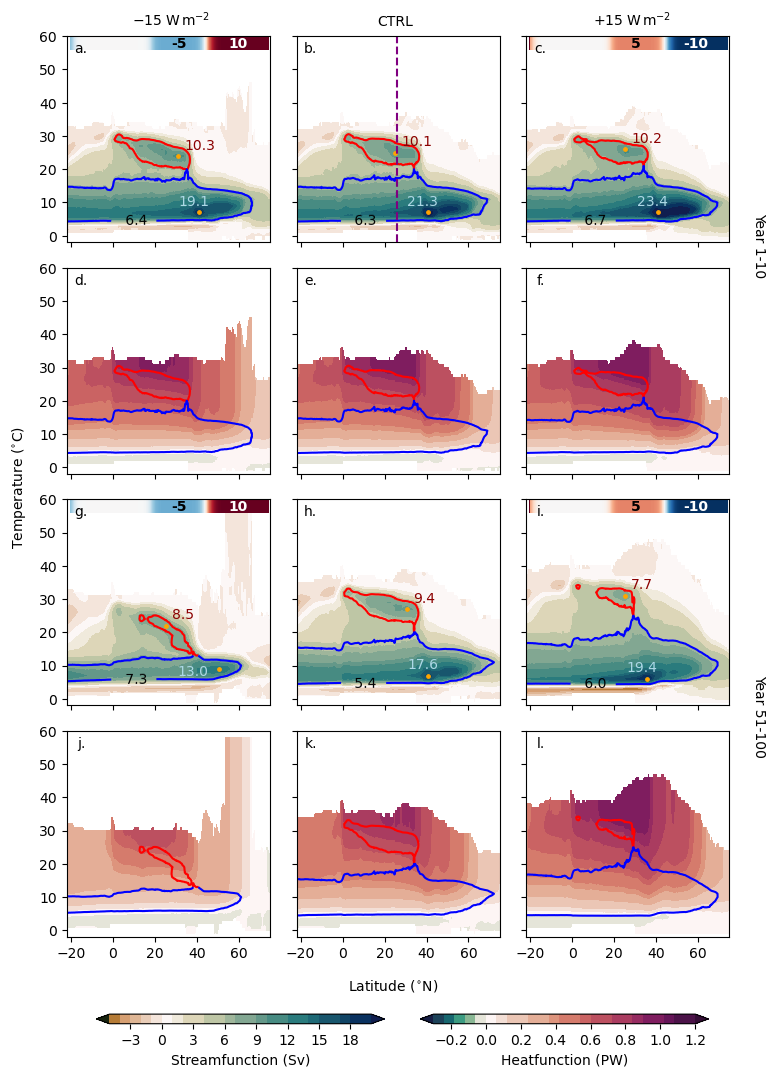

In [6]:
ϵ = 1e-3
expt = ['Neg10W', 'CTRL', 'Pos10W']
label_series = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.', 'h.', 'i.', 'j.', 'k.', 'l.']

# Streamfunction plots (First 10 years (a-c) and last 50 years (g-i))
# Heatfunction plots(First 10 years (d-f) and last 50 years (h-l))

# Step 1: Non-uniform colorbar preparation for streamfunction (Ψ) and heatfunction (α)
# (i) Streamfunction colorbar 
vminΨ, vmaxΨ = -5, 20
clevΨ  = np.linspace(vminΨ, vmaxΨ, (vmaxΨ - vminΨ) + 1)
divnΨ  = colors.TwoSlopeNorm(vmin = vminΨ * 2, vcenter = 0., vmax = vmaxΨ)
# (ii) Heatfunction colorbar
vminα, vmaxα = -0.3, 1.2
clevα = np.linspace(vminα, vmaxα, 26)
divnα  = colors.TwoSlopeNorm(vmin = vminα, vcenter = 0., vmax = vmaxα)

# Step 2: Declare variables for maximum value of the streamfunction at warm and cold temperatures (resembling the subtropical gyre 
# and the dense overturning circulation respectively)
Ψmax_gyre = np.zeros((3, 2))
Ψmax_AMOC = np.zeros((3, 2))

# Step 3: Pick start (st) and end (et) dates of interest (here chosen to be first 10 and last 50 years)
st = ['2202-01-01', '2252-01-01']
et = ['2211-12-31', '2301-12-31']

# Step 4: Location of data (will be available at a Zenodo repository upon acceptance of manuscript)
dirc1 = '/g/data/x77/db6174/MHT_calculations/NETCDF/Heatfunction_split/Psi_components/'
dirc2 = '/scratch/x77/db6174/MHT_FF11/Psi_Atlantic_temperature_space/'

# Step 5: Creating figures with required panels
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (6 * 1.2, 8 * 1.2))

# The variable i and j are used to reference to experiments and time periods of interest respectively
for i in range(3):
    for j in range(2):
        
        if(j == 0):      # First 10 years
            Ψs = xr.load_dataset(dirc1 + expt[i] + '_10yr_avg.nc').Mixed.sel(time = slice(st[j], et[j]))
            θs = xr.load_dataset(dirc1 + expt[i] + '_10yr_avg.nc').Saddle_temp.sel(time = slice(st[j], et[j]))
        elif(j == 1):    # Last 10 years
            Ψs = xr.load_dataset(dirc1 + expt[i] + '_50yr_avg.nc').Mixed.sel(time = slice(st[j], et[j]))
            θs = xr.load_dataset(dirc1 + expt[i] + '_50yr_avg.nc').Saddle_temp.sel(time = slice(st[j], et[j]))

        Ψ =  xr.load_dataset(dirc2 + expt[i] + '.nc').AMOC.sel(time = slice(st[j], et[j])).mean('time').rolling(temp = 2, min_periods = 1).mean()

        ## Creating streamfunction plots
        Ψ_cor = xr.where(Ψ == Ψ.isel(temp = -1), np.nan, xr.where(Ψ == 0, np.nan, Ψ)).sel(yu_ocean = slice(-22, None))
        p1 = Ψ_cor.plot.contourf(y = 'temp', levels = clevΨ, cmap = cm.cm.tarn,   ax = axes[j*2][i], add_colorbar = False, norm = divnΨ, extend = 'both')
        p4 = Ψ_cor.where(Ψ_cor.temp >= θs[0].values).plot.contour(y = 'temp', ax = axes[j*2][i], levels = np.linspace(Ψs[0].values, Ψs[0].values + ϵ, 1), cmap = 'red')
        p3 = Ψ_cor.where(Ψ_cor.temp <= θs[0].values).plot.contour(y = 'temp', ax = axes[j*2][i], levels = np.linspace(Ψs[0].values, Ψs[0].values + ϵ, 1), cmap = 'blue')
        axes[j*2][i].clabel(p3, p3.levels, inline = True, fmt ='% 1.1f', fontsize = 10, colors = 'black', manual = [(10, 5)])
        
        ## Finding maximum warm cell streamfunction value and plotting it as text
        temp_array = Ψ_cor.where(Ψ_cor.temp >= θs[0].values)
        Ψmax_gyre[i][j] = temp_array.max().values
        index = unravel_index(temp_array.argmax(), temp_array.shape)
        x, y = temp_array[index].temp.values.item(), temp_array[index].yu_ocean.values.item()
        axes[j*2][i].scatter(y, x, marker = 'o', color = 'orange', s = 6)
        axes[j*2][i].text(y + 3, x + 2, np.round(Ψmax_gyre[i][j], 1), color = 'darkred')

        ## Finding maximum cold cell streamfunction value and plotting it as text
        temp_array = Ψ_cor.where(Ψ_cor.temp <= θs[0].values)
        Ψmax_AMOC[i][j] = temp_array.max().values
        index = unravel_index(temp_array.argmax(), temp_array.shape)
        x, y = temp_array[index].temp.values.item(), temp_array[index].yu_ocean.values.item()
        axes[j*2][i].scatter(y, x, marker = 'o', color = 'orange', s = 6)
        if(i == 0 and j == 1):
            axes[j*2][i].text(y - 20, x - 2, np.round(Ψmax_AMOC[i][j], 1), color = 'lightblue')
        else:
            axes[j*2][i].text(y - 10, x + 2, np.round(Ψmax_AMOC[i][j], 1), color = 'lightblue')

        ## Creating heatfunction plots
        α = Ψ_cor.cumsum('temp') * ((ρ0 * Cp * 1e6)/(1e15))
        α_cor = xr.where(α == α.isel(temp = -1), np.nan, xr.where(α == 0, np.nan, α)).sel(yu_ocean = slice(-22, None))
        p2 = α_cor.plot.contourf(y = 'temp', levels = clevα, cmap = cm.cm.curl, ax = axes[j*2+1][i], add_colorbar = False, norm = divnα, extend = 'both') 
        p4 = Ψ_cor.where(Ψ_cor.temp >= θs[0].values).plot.contour(y = 'temp', ax = axes[j*2+1][i], levels = np.linspace(Ψs[0].values, Ψs[0].values + ϵ, 1), cmap = 'red')
        p3 = Ψ_cor.where(Ψ_cor.temp <= θs[0].values).plot.contour(y = 'temp', ax = axes[j*2+1][i], levels = np.linspace(Ψs[0].values, Ψs[0].values + ϵ, 1), cmap = 'blue')

## Heat mask contour on top of plots to denote the surface meridional heat flux contrast applied
heat_mask = xr.load_dataset('/g/data/x77/db6174/Flux_forced_models/025deg_flux_forced_uniform/Netcdf/normalized_heat_mask.nc')
hm_temp = heat_mask.mask.sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(-20, 74)).mean('xt_ocean')
hm_temp[0] = 1
my_cmap = plt.get_cmap('RdBu_r')
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

## Labelling the magnitude of heat fluxes (positive and negative maxima)
for i in ([0, 2]):
    axes[i][0].bar(hm_temp.yt_ocean, height = 4, width = 1, bottom = 56, color = my_cmap(rescale(-hm_temp.values)))
    axes[i][2].bar(hm_temp.yt_ocean, height = 4, width = 1, bottom = 56, color = my_cmap(rescale( hm_temp.values)))
    axes[i][0].text(28, 56.5, str(-5), color='black', fontweight='bold')
    axes[i][0].text(55, 56.5, str(10), color='white', fontweight='bold')
    axes[i][2].text(28, 56.5, str(5), color='black', fontweight='bold')
    axes[i][2].text(53, 56.5, str(-10), color='white', fontweight='bold')

## x and y ticks
for i in range(4):
    for j in range(3):
        axes[i][j].set_ylabel('')
        axes[i][j].set_xlabel('')
        axes[i][j].set_xticks([-20, 0, 20, 40, 60])
        axes[i][j].set_yticks([0, 10, 20, 30, 40, 50, 60])
        axes[i][j].set_title(label_series[i*3 + j], fontsize = 10, x = 0.07, y = 1, pad = -12)

# Ensuring that only the last row has xticks printed, others are left blank
for i in range(3):
    for j in range(3):
        axes[i][j].set_xticklabels([])

# Ensuring that only the first column has yticks printed, others are left blank
for i in range(2):
    for j in range(4):
        axes[j][i+1].set_yticklabels([])

# Plotting 26N in the first 10 years of the control simulation to highlight which latitude we pick to summarize our results
axes[0][1].axvline(26, ls = '--', color = 'purple', lw = 1.5)

## Colorbars
## Colorbar 1: Overturning circulation
ax_cb = plt.axes([0.1, -0.05, 0.4, 0.01])
cb = plt.colorbar(p1, cax = ax_cb, orientation = 'horizontal')
cb.ax.set_xlabel('Streamfunction (Sv)', fontsize = 10)

## Colorbar 2: Heatfunction value
ax_cb = plt.axes([0.55, -0.05, 0.4, 0.01])
cb = plt.colorbar(p2, cax = ax_cb, orientation = 'horizontal')
cb.ax.set_xlabel('Heatfunction (PW)', fontsize = 10)
cb.ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])

## x and y labels
fig.text(-0.02, 0.45, 'Temperature ($^{\circ}$C)', rotation = 90)
fig.text(0.45, -0.015, 'Latitude ($^{\circ}$N)')

## First 10 vs last 50 years labeling
fig.text(1.01, 0.73, 'Year 1-10', rotation = -90)
fig.text(1.01, 0.23, 'Year 51-100', rotation = -90)

## Experiment labeling
fig.text(0.15, 0.99, '$-15 \;\mathrm{W}\,\mathrm{m}^{-2}$')
fig.text(0.49, 0.99, 'CTRL')
fig.text(0.79, 0.99, '$+15 \;\mathrm{W}\,\mathrm{m}^{-2}$')

fig.tight_layout()

#plt.savefig('Figures/Surface_heat_contrast_streamfunction_heatfunction.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## Figure 3: Summary plots at 26$^{\circ}$N for wind stress and surface heat flux perturbation experiments

In [7]:
st = ['2202-01-01', '2252-01-01']
et = ['2211-12-31', '2301-12-31']

In [8]:
def heat_transport_metrics(start_time, end_time, nx, expt_label, year_avg_label, expt_switch):
    ηgyre, ηAMOC, ηmixed = np.zeros(nx), np.zeros(nx), np.zeros(nx)
    σgyre, σAMOC, σmixed = np.zeros(nx), np.zeros(nx), np.zeros(nx)
    
    Ψgyre,  ΨAMOC,  Ψmixed  = np.zeros(nx), np.zeros(nx), np.zeros(nx)
    MHTgyre,  MHTAMOC,  MHTmixed  = np.zeros(nx), np.zeros(nx), np.zeros(nx)
    θgyre, θAMOC, θmixed = np.zeros(nx), np.zeros(nx), np.zeros(nx)

    for i, j in enumerate(expt_label):
        MHT = xr.load_dataset('/g/data/x77/db6174/MHT_calculations/NETCDF/Heatfunction_split/MHT_Atlantic/' + j + '_' + year_avg_label + '.nc')
        Ψ = xr.load_dataset('/g/data/x77/db6174/MHT_calculations/NETCDF/Heatfunction_split/Psi_components/' + j + '_' + year_avg_label + '.nc')
        ΔT = xr.load_dataset('/g/data/x77/db6174/MHT_calculations/NETCDF/Heatfunction_split/Temperature_contrast/' + expt_switch + '_' + year_avg_label + '.nc')

        ## Row 1: Circulation (Sv)
        Ψgyre[i]   = Ψ.Gyre. sel(time = slice(start_time, end_time)).mean('time').values
        ΨAMOC[i]   = Ψ.AMOC. sel(time = slice(start_time, end_time)).mean('time').values
        Ψmixed[i]  = Ψ.Mixed.sel(time = slice(start_time, end_time)).mean('time').values

        ## Row 2: MHT (W/m2)
        MHTgyre[i]   = MHT.Gyre. sel(time = slice(start_time, end_time)).mean('time').values
        MHTAMOC[i]   = MHT.AMOC. sel(time = slice(start_time, end_time)).mean('time').values
        MHTmixed[i]  = MHT.Mixed.sel(time = slice(start_time, end_time)).mean('time').values

    ## Row 3: Temperature contrast (degree C)
    θgyre  = ΔT.Gyre. sel(time = slice(start_time, end_time))[0].values
    θAMOC  = ΔT.AMOC. sel(time = slice(start_time, end_time))[0].values
    θmixed = ΔT.Mixed.sel(time = slice(start_time, end_time))[0].values

    return Ψgyre, ΨAMOC, Ψmixed, MHTgyre,  MHTAMOC,  MHTmixed, θgyre, θAMOC, θmixed

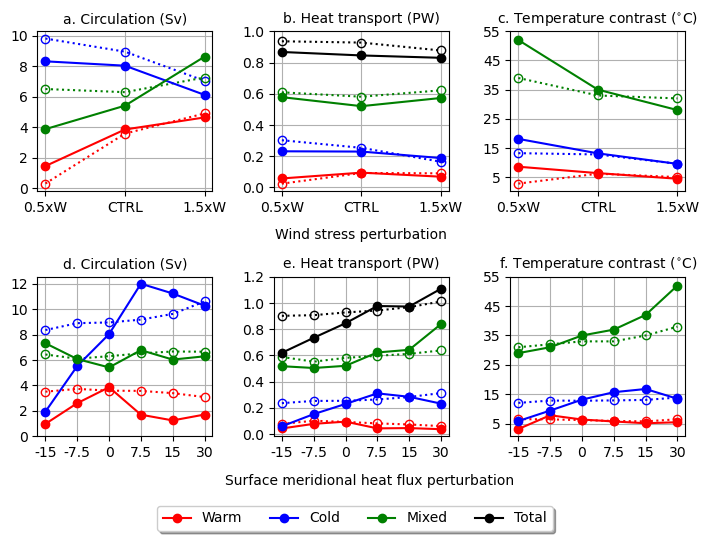

In [9]:
## Experiment names
label_wind = ['050xS', 'CTRL', '150xS']
label_heat = ['Neg10W', 'Neg5W', 'CTRL', 'Pos5W', 'Pos10W', 'Pos20W']

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (6 * 1.2, 4 * 1.2))

# i = 0 corresponds to the first 10 years, and i = 1 corresponds to the last 10 yers.
for i in range(2):

    if(i == 0):
        lstyle, mfill = ':', 'none'
        year_avg_label = '10yr_avg'
    else:
        lstyle, mfill = '-', 'full'
        year_avg_label = '50yr_avg'
        
    ## Part 1: Metrics for wind perturbation experiments
    nx = 3      # = number of experiments (0.5xW, CTRL, 1.5xW)
    xaxis = np.arange(0, nx, 1)

    # Getting data (which will be available upon acceptance of the manuscript) for streamfunction, MHT, and temperature range for each circulation cell
    Ψgyre, ΨAMOC, Ψmixed, MHTgyre, MHTAMOC, MHTmixed, θgyre, θAMOC, θmixed = heat_transport_metrics(st[i], et[i], nx, label_wind, year_avg_label, 'Wind')

    # Plotting data for wind perturbation experiments
    if(i == 1):
        axes[0][0].plot(xaxis, Ψgyre,  ls = lstyle, marker = 'o', markersize = 6, color = 'red',  label = 'Warm', fillstyle = mfill)
        axes[0][0].plot(xaxis, ΨAMOC,  ls = lstyle, marker = 'o', markersize = 6, color = 'blue',   label = 'Cold', fillstyle = mfill)
        axes[0][0].plot(xaxis, Ψmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'green', label = 'Mixed', fillstyle = mfill)
        axes[0][1].plot(xaxis, MHTAMOC + MHTgyre + MHTmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'black', label = 'Total', fillstyle = mfill)
    else:
        axes[0][0].plot(xaxis, Ψgyre,  ls = lstyle, marker = 'o', markersize = 6, color = 'red' , fillstyle = mfill)
        axes[0][0].plot(xaxis, ΨAMOC,  ls = lstyle, marker = 'o', markersize = 6, color = 'blue'  , fillstyle = mfill)
        axes[0][0].plot(xaxis, Ψmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'green', fillstyle = mfill)
        axes[0][1].plot(xaxis, MHTAMOC + MHTgyre + MHTmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'black', fillstyle = mfill)
        
    axes[0][1].plot(xaxis, MHTgyre,  ls = lstyle, marker = 'o', markersize = 6, color = 'red' , fillstyle = mfill)
    axes[0][1].plot(xaxis, MHTAMOC,  ls = lstyle, marker = 'o', markersize = 6, color = 'blue'  , fillstyle = mfill)
    axes[0][1].plot(xaxis, MHTmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'green', fillstyle = mfill)

    axes[0][2].plot(xaxis, θgyre,  ls = lstyle, marker = 'o', markersize = 6, color = 'red' , fillstyle = mfill)
    axes[0][2].plot(xaxis, θAMOC,  ls = lstyle, marker = 'o', markersize = 6, color = 'blue' , fillstyle = mfill)
    axes[0][2].plot(xaxis, θmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'green' , fillstyle = mfill)

    ## Part 2: Metrics for surface heat flux contrast experiments
    nx = 6     # = number of experiments (Neg10W, Neg5W, CTRL, Pos5W, Pos10W, Pos20W)
    xaxis = np.arange(0, nx, 1)

    # Getting data (which will be available upon acceptance of the manuscript) for streamfunction, MHT, and temperature range for each circulation cell
    Ψgyre, ΨAMOC, Ψmixed, MHTgyre, MHTAMOC, MHTmixed, θgyre, θAMOC, θmixed = heat_transport_metrics(st[i], et[i], nx, label_heat, year_avg_label, 'Heat')

    # Plotting data for surface heat flux contrast experiments
    axes[1][0].plot(xaxis, Ψgyre,  ls = lstyle, marker = 'o', markersize = 6, color = 'red' , fillstyle = mfill)
    axes[1][0].plot(xaxis, ΨAMOC,  ls = lstyle, marker = 'o', markersize = 6, color = 'blue'  , fillstyle = mfill)
    axes[1][0].plot(xaxis, Ψmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'green', fillstyle = mfill)
    axes[1][1].plot(xaxis, MHTAMOC + MHTgyre + MHTmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'black', fillstyle = mfill)

    axes[1][1].plot(xaxis, MHTgyre,  ls = lstyle, marker = 'o', markersize = 6, color = 'red' , fillstyle = mfill)
    axes[1][1].plot(xaxis, MHTAMOC,  ls = lstyle, marker = 'o', markersize = 6, color = 'blue'  , fillstyle = mfill)
    axes[1][1].plot(xaxis, MHTmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'green', fillstyle = mfill)

    axes[1][2].plot(xaxis, θgyre,  ls = lstyle, marker = 'o', markersize = 6, color = 'red' , fillstyle = mfill)
    axes[1][2].plot(xaxis, θAMOC,  ls = lstyle, marker = 'o', markersize = 6, color = 'blue' , fillstyle = mfill)
    axes[1][2].plot(xaxis, θmixed, ls = lstyle, marker = 'o', markersize = 6, color = 'green' , fillstyle = mfill)

# Plotting x and y ticks for all 6 panels
xaxis = np.arange(0, 3, 1)
xticks = ['0.5xW', 'CTRL', '1.5xW']
for j in range(3):
    axes[0][j].set_xticks(xaxis, xticks, fontsize = 10)

ylabel1 = np.arange(0, 12, 2)
ylabel2 = np.arange(0, 12, 2) * 1e14
ylabel3 = np.arange(5, 65, 10)
axes[0][0].set_yticks(ticks = ylabel1, labels = ylabel1, fontsize = 10)
axes[0][1].set_yticks(ticks = ylabel2, labels = ylabel2/1e15, fontsize = 10)
axes[0][2].set_yticks(ticks = ylabel3, labels = ylabel3, fontsize = 10)

xaxis = np.arange(0, 6, 1)
xticks = ['-15', '-7.5', '0', '7.5', '15', '30']
for j in range(3):
    axes[1][j].set_xticks(xaxis, xticks, fontsize = 10)

ylabel1 = np.arange(0, 14, 2)
ylabel2 = np.arange(0, 14, 2) * 1e14
ylabel3 = np.arange(5, 65, 10)
axes[1][0].set_yticks(ticks = ylabel1, labels = ylabel1, fontsize = 10)
axes[1][1].set_yticks(ticks = ylabel2, labels = ylabel2/1e15, fontsize = 10)
axes[1][2].set_yticks(ticks = ylabel3, labels = ylabel3, fontsize = 10)

# Gridding panels
for i in range(2):
    for j in range(3):
        axes[i][j].grid()

# Title for each panel
axes[0][0].set_title('a. Circulation (Sv)', fontsize = 10)
axes[0][1].set_title('b. Heat transport (PW)', fontsize = 10)
axes[0][2].set_title('c. Temperature contrast ($^{\circ}$C)', fontsize = 10)
axes[1][0].set_title('d. Circulation (Sv)', fontsize = 10)
axes[1][1].set_title('e. Heat transport (PW)', fontsize = 10)
axes[1][2].set_title('f. Temperature contrast ($^{\circ}$C)', fontsize = 10)

# Labelling wind and surface heat flux contrast experiments
axes[0][1].set_xlabel('Wind stress perturbation', labelpad = 10)
fig.text(0.32, -0.02, 'Surface meridional heat flux perturbation', fontsize = 10)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4, fontsize = 10)
fig.tight_layout()

#plt.savefig('/g/data/x77/db6174/MHT_calculations/2024_paper_figures/Heatfunction-split/Wind_heat_summary.pdf', 
#            bbox_inches = 'tight', dpi = 300, transparent=True)